## Introduction

This workbook contains the exploratory data analysis for Making the News on r/news. A number of high-level descriptive statistics were performed on the dataset as well as some basic visualizations. These were performed in order to guide the model selection process.

### Table of Contents

1. [Imports](#Imports)
2. [Engagement correlation and box plots](#Corr)
2. [Visualizations with Target](#Viz)

### 1. Imports <a class="anchor" id="Imports"></a>

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from langdetect import detect
import spacy
from sklearn.metrics import roc_curve, auc

In [2]:
# Load dataset

data = pd.read_csv('r_news_top_jan_to_may_2021.csv')
data = data.drop('Unnamed: 0', axis=1)

In [3]:
# Basic stats and info
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11240 entries, 0 to 11239
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Post ID                11240 non-null  object
 1   Title                  11240 non-null  object
 2   Url                    11240 non-null  object
 3   Author                 11240 non-null  object
 4   Score                  11240 non-null  int64 
 5   Publish Date           11240 non-null  object
 6   Total No. of Comments  11240 non-null  int64 
 7   Permalink              11240 non-null  object
 8   Flair                  1406 non-null   object
 9   duplicate              11240 non-null  bool  
 10  Engagement             11240 non-null  int64 
dtypes: bool(1), int64(3), object(7)
memory usage: 889.2+ KB


,Score,Total No. of Comments,Engagement
count,11240.000000,11240.000000,11240.000000
mean,348.642527,315.755249,664.397776
std,3859.455582,1137.370254,4369.823990
min,0.000000,0.000000,10.000000
25%,1.000000,16.000000,21.000000
50%,1.000000,40.000000,52.000000
75%,6.250000,154.000000,192.000000
max,103302.000000,41107.000000,117980.000000


### 2. Engagement correlation and box plots<a class="anchor" id="Corr"></a>

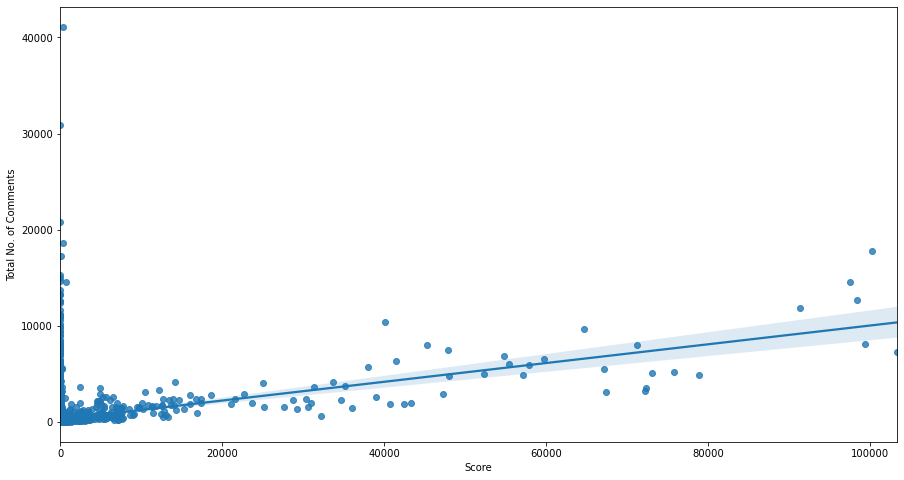

In [4]:
# Check relationship between Score and # Comments
plt.figure(figsize=(15,8))
sns.regplot(x=data.Score, y=data['Total No. of Comments'])
plt.savefig('r_news_score_comm.png')
plt.show()

There are clear outliers in both directions, and a pretty weak positive relationship. Engagement doesn't seem to be useful in aggregate, but is good to set the cutoff for our data set. 

# Headline Information

# Words

In [5]:
# Create column of word lists and word counts
# Correct case of column and eliminate special characters

data['title_case_correct'] = data['Title'].str.lower()
data['title_case_correct'] = data['title_case_correct'].astype(str).replace('[^a-zA-Z0-9 ]','',regex=True)
data['title_words'] = data['title_case_correct'].str.split()

In [6]:
# One more col minus stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['title_words'] = data['title_words'].apply(lambda x: [item for item in x if item not in stop])

In [7]:
# Drop rows that are in other languages
data['language'] = data['title_case_correct'].apply(detect)
data = data[data['language'] == 'en']

In [8]:
# Lemmatize title and words

nlp = spacy.load('en_core_web_sm')

In [9]:
data['lemmatized'] = data['title_case_correct']

In [10]:
data['lemmatized'] = data['lemmatized'].apply(lambda row: " ".join(w.lemma_ for w in nlp(row)))

In [11]:
data['lemmatized_words'] = data['lemmatized'].str.split()

In [12]:
data['lemmatized_words'] = data['lemmatized_words'].apply(lambda x: [item for item in x if item not in stop])

In [13]:
# Add Percentile to the headlines

data['score_percentile'] = data.Score.rank(pct=True)
data['comments_percentile'] = data['Total No. of Comments'].rank(pct=True)
data['engagement_percentile'] = data.Engagement.rank(pct=True)

In [14]:
# Convert percentiles to bands (Top 10, Middle 40, Bottom 50)
bands = [(data['score_percentile'] >= .95), (data['score_percentile'] < .95) & (data['score_percentile'] > .5), (data['score_percentile'] <= .5)]
values = ['Top 5', 'Middle 45', 'Bottom 50']
data['score_band'] = np.select(bands, values)

In [15]:
# Convert percentiles to bands (Top 10, Middle 40, Bottom 50) for comments now
bands = [(data['comments_percentile'] >= .95), (data['comments_percentile'] < .95) & (data['comments_percentile'] > .5), (data['comments_percentile'] <= .5)]
values = ['Top 5', 'Middle 45', 'Bottom 50']
data['comm_band'] = np.select(bands, values)

In [16]:
# Convert percentiles to bands (Top 10, Middle 40, Bottom 50) for comments now
bands = [(data['engagement_percentile'] >= .95), (data['engagement_percentile'] < .95) & (data['engagement_percentile'] > .5), (data['engagement_percentile'] <= .5)]
values = ['Top 5', 'Middle 45', 'Bottom 50']
data['eng_band'] = np.select(bands, values)

In [17]:
# Make data sets for each band
data_score_5 = data[data['score_band'] == 'Top 5']
data_score_45 = data[data['score_band'] == 'Middle 45']
data_score_50 = data[data['score_band'] == 'Bottom 50']
data_comm_5 = data[data['comm_band'] == 'Top 5']
data_comm_45 = data[data['comm_band'] == 'Middle 45']
data_comm_50 = data[data['comm_band'] == 'Bottom 50']
data_eng_5 = data[data['eng_band'] == 'Top 5']
data_eng_45 = data[data['eng_band'] == 'Middle 45']
data_eng_50 = data[data['eng_band'] == 'Bottom 50']

In [18]:
data.describe()

,Score,Total No. of Comments,Engagement,score_percentile,comments_percentile,engagement_percentile
count,10843.000000,10843.000000,10843.000000,10843.000000,10843.000000,10843.000000
mean,352.156968,316.693904,668.850872,0.500046,0.500046,0.500046
std,3865.052541,1140.124157,4379.986098,0.247165,0.288666,0.288664
min,0.000000,0.000000,10.000000,0.005165,0.006825,0.017661
25%,1.000000,16.000000,21.000000,0.332196,0.254542,0.254312
50%,1.000000,40.000000,52.000000,0.332196,0.498893,0.500138
75%,7.000000,155.000000,193.000000,0.754773,0.749839,0.750208
max,103302.000000,41107.000000,117980.000000,1.000000,1.000000,1.000000


In [19]:
#get names of df for use in loops


def df_name(df):
    name = [x for x in globals() if globals()[x] is df][0]
    return name

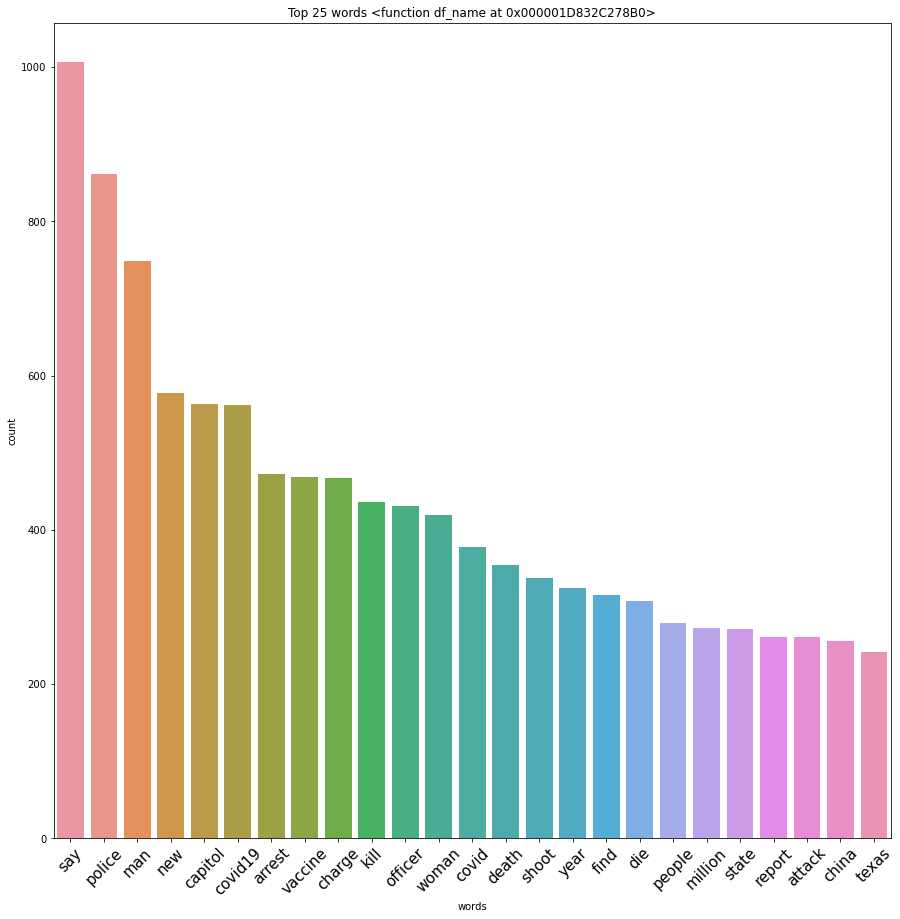

In [20]:
# Count and plot of most frequent words

words = data['lemmatized_words'].explode()
words_df = pd.DataFrame(words.value_counts())
words_df = words_df.reset_index()
words_df.columns = ['words','count']
top_25_words = words_df.head(25)

plt.figure(figsize=(15,15))
sns.barplot(x=top_25_words['words'], y=top_25_words['count'])
plt.title("Top 25 words " + str(df_name))
plt.xticks(rotation=45, size=15)

plt.show()

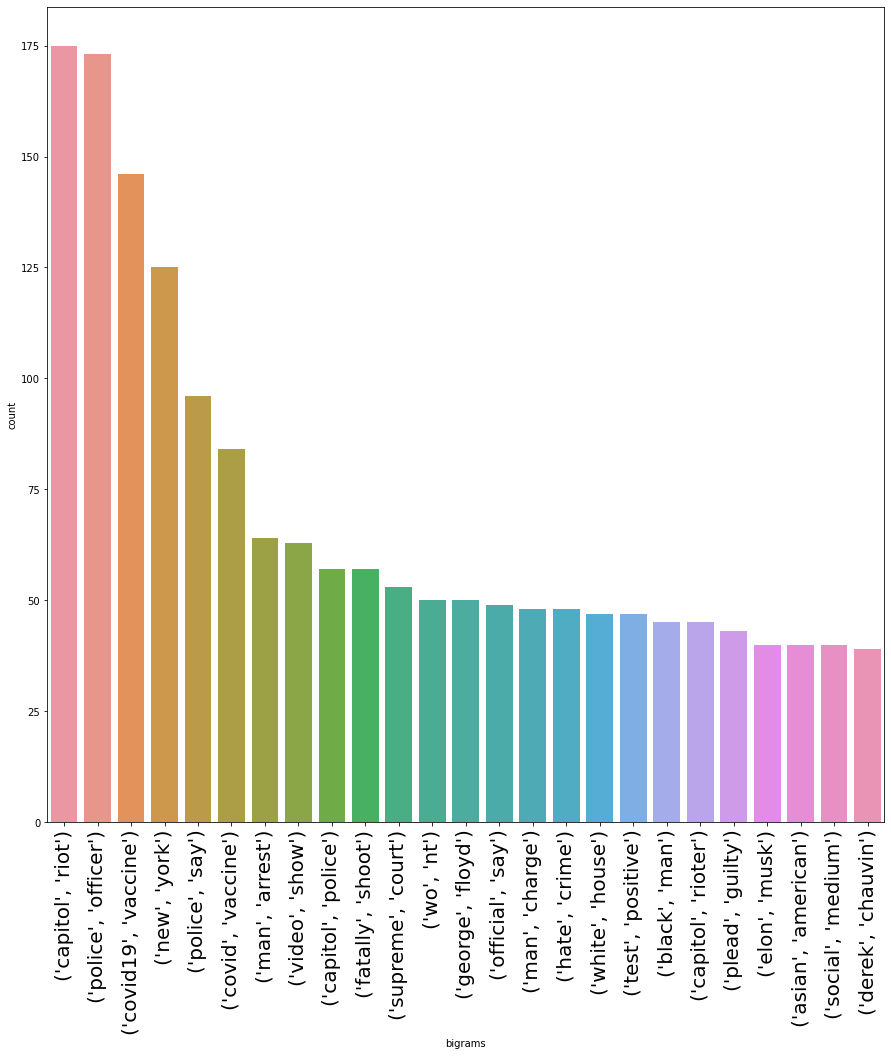

In [21]:
bigrams = pd.Series(nltk.ngrams(words,2)).value_counts()
bigrams_df = pd.DataFrame(bigrams)
bigrams_df = bigrams_df.reset_index()
bigrams_df.columns = ['bigrams','count']
top_25_bigrams = bigrams_df.head(25)

plt.figure(figsize=(15,15))
sns.barplot(x=top_25_bigrams['bigrams'], y=top_25_bigrams['count'])
plt.xticks(rotation=90, size=20)
plt.show()

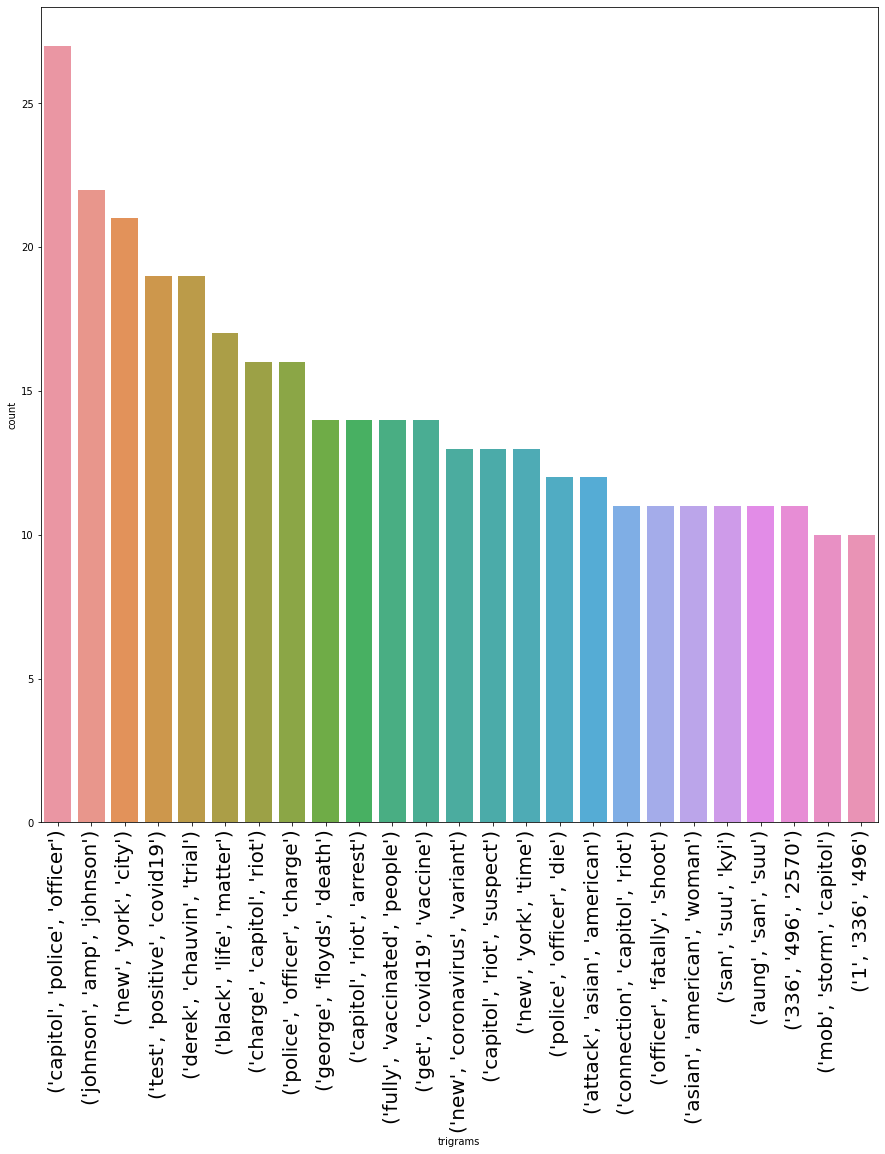

In [22]:
trigrams = pd.Series(nltk.ngrams(words,3)).value_counts()
trigrams_df = pd.DataFrame(trigrams)
trigrams_df = trigrams_df.reset_index()
trigrams_df.columns = ['trigrams','count']
top_25_trigrams = trigrams_df.head(25)

plt.figure(figsize=(15,15))
sns.barplot(x=top_25_trigrams['trigrams'], y=top_25_trigrams['count'])
plt.xticks(rotation=90, size=20)
plt.show()

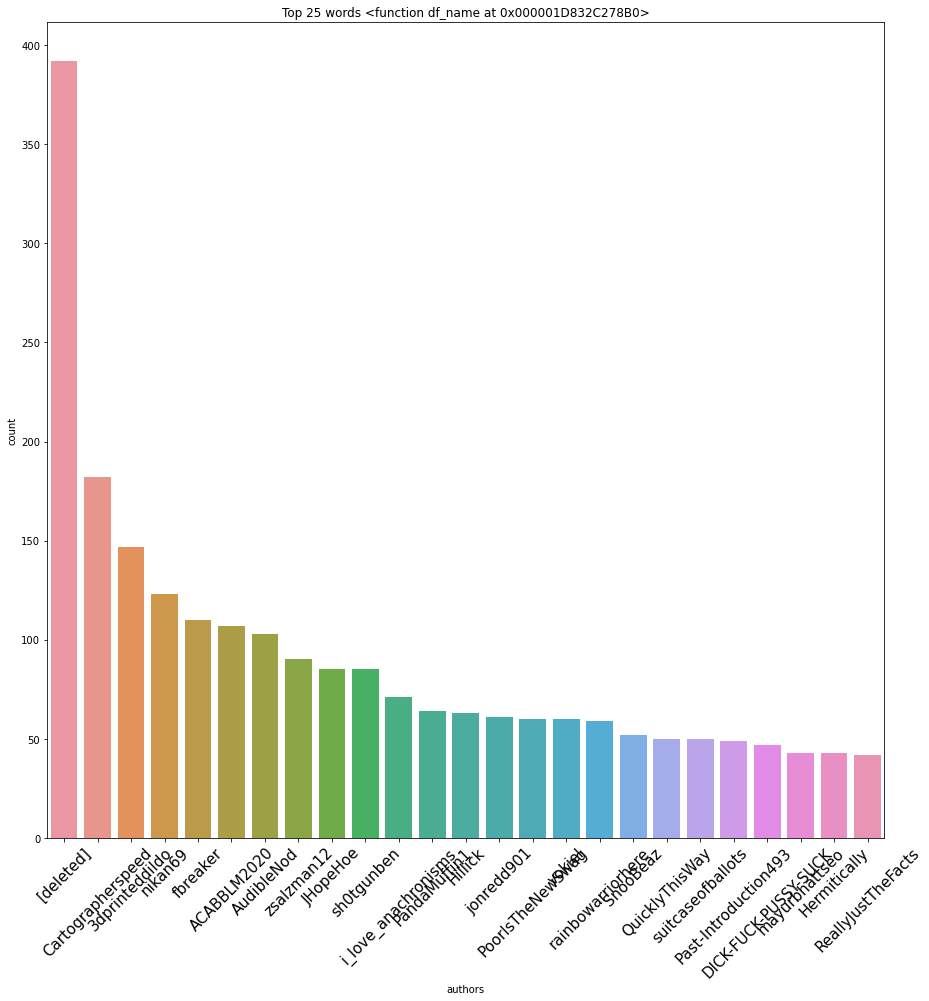

In [23]:

authors_df = pd.DataFrame(data['Author'].value_counts())
authors_df = authors_df.reset_index()
authors_df.columns = ['authors','count']
top_25_authors = authors_df.head(25)

plt.figure(figsize=(15,15))
sns.barplot(x=top_25_authors['authors'], y=top_25_authors['count'])
plt.title("Top 25 words " + str(df_name))
plt.xticks(rotation=45, size=15)

plt.show()

In [24]:
authors_df = pd.DataFrame(data['Author'].value_counts())
authors_df = authors_df.reset_index()
authors_df.columns = ['authors','count']

authors_df

,authors,count
0,[deleted],392
1,Cartographerspeed,182
2,3dprinteddildo,147
3,nikan69,123
4,fbreaker,110
...,...,...
3893,TimothyMurphy1776,1
3894,snlol,1
3895,OzamatazzBuckshanks,1
3896,hey_geronimoo,1


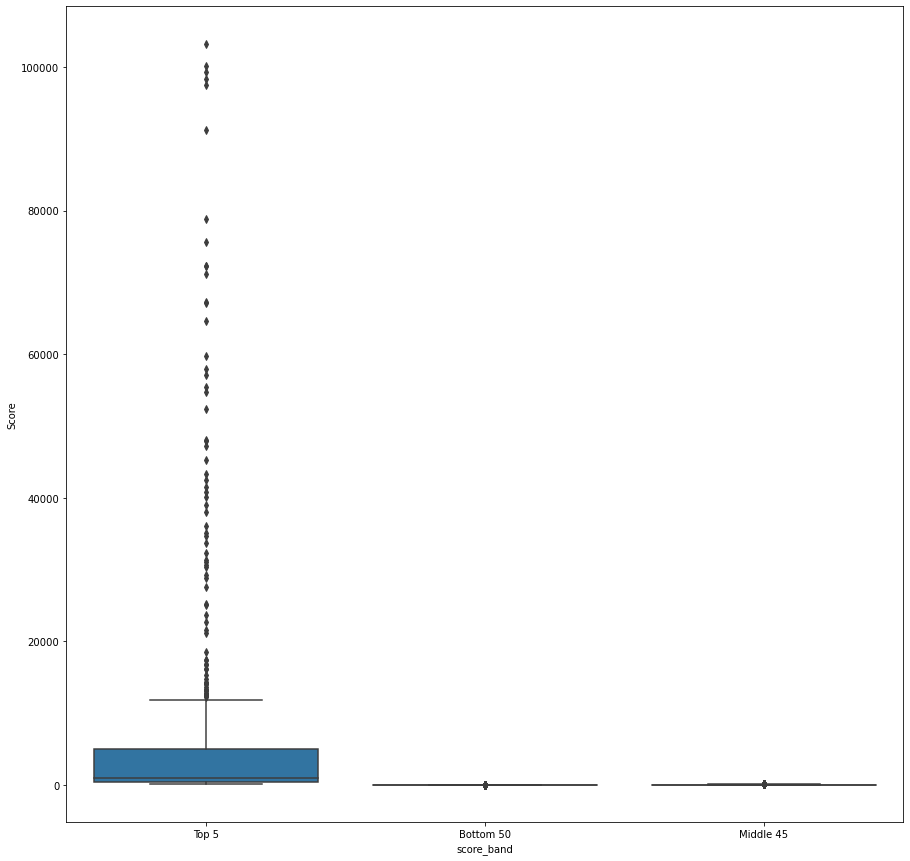

In [25]:
plt.figure(figsize=(15,15))
sns.boxplot(data=data['Score'], x=data['score_band'], y=data['Score'])
plt.savefig('r_news_eng_comp.png')
plt.show()

<AxesSubplot:xlabel='comm_band', ylabel='Total No. of Comments'>

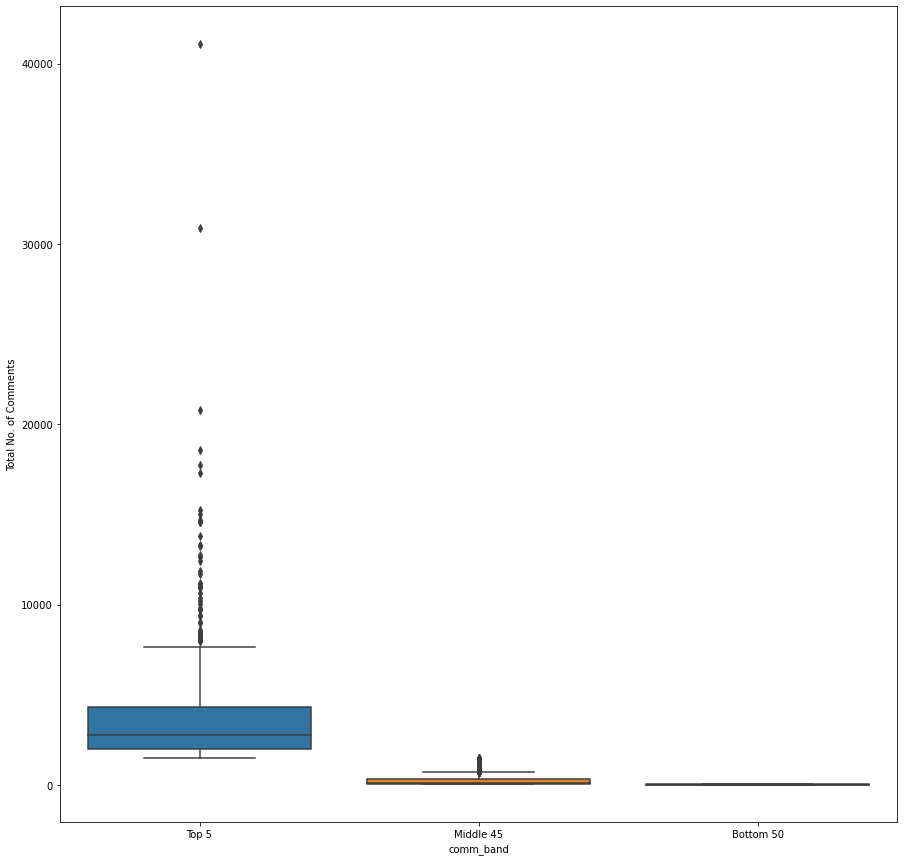

In [26]:
plt.figure(figsize=(15,15))
sns.boxplot(data=data['Total No. of Comments'], x=data['comm_band'], y=data['Total No. of Comments'])

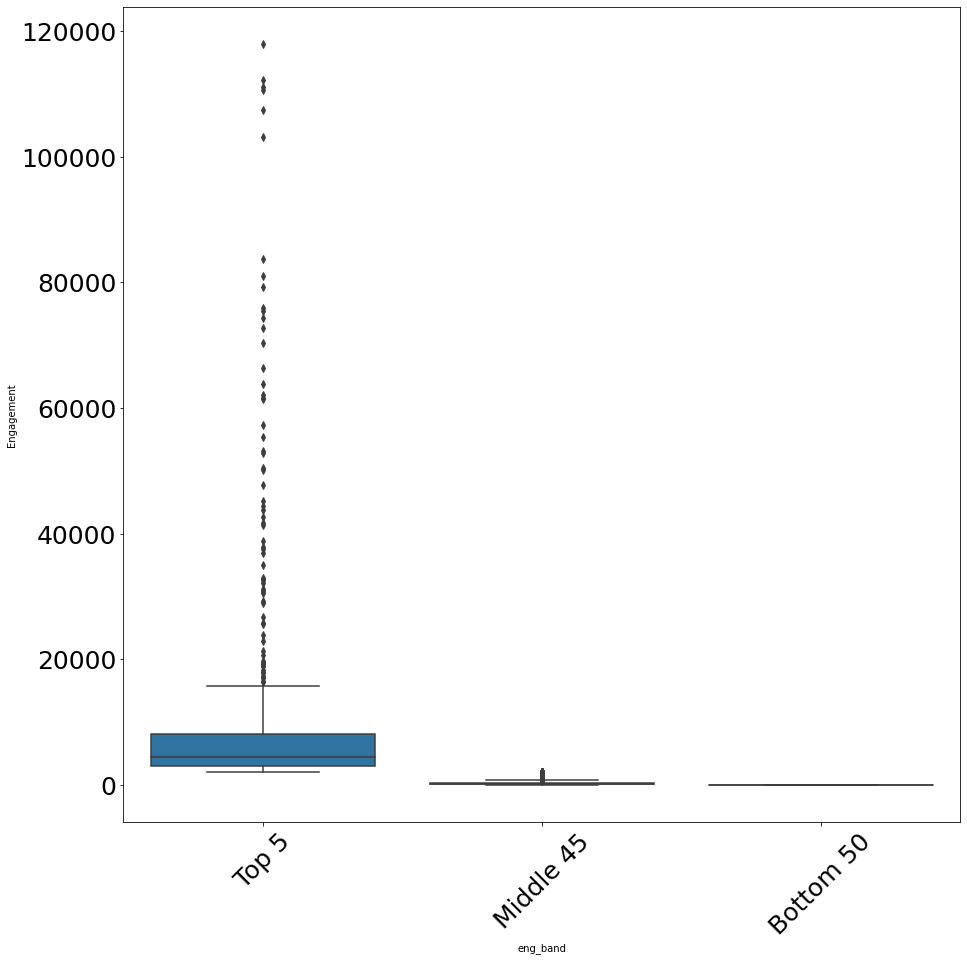

In [27]:
plt.figure(figsize=(15,15))
sns.boxplot(data=data['Engagement'], x=data['eng_band'], y=data['Engagement'])
plt.xticks(size=25, rotation=45)
plt.yticks(size=25)
plt.savefig('r_news_eng_comp.png')
plt.show()

In [28]:
# Colossal gap beteen top story's score and bottom story's, even within the band
# Consider a 1%/49%/50% split

data[data['score_band']=='Top 5'].describe()

,Score,Total No. of Comments,Engagement,score_percentile,comments_percentile,engagement_percentile
count,542.000000,542.000000,542.000000,542.000000,542.000000,542.000000
mean,6879.195572,1056.387454,7935.583026,0.975053,0.780220,0.917055
std,15951.294414,2684.829289,17621.537839,0.014443,0.185820,0.068972
min,179.000000,6.000000,191.000000,0.950106,0.053260,0.748501
25%,336.250000,102.500000,507.250000,0.962556,0.690422,0.862250
50%,932.000000,294.500000,1372.000000,0.975053,0.829498,0.930969
75%,4937.750000,860.500000,6046.750000,0.987527,0.922150,0.982639
max,103302.000000,41107.000000,117980.000000,1.000000,1.000000,1.000000


In [29]:
# Not a dramatic of a gap, but still very high

data[data['comm_band']=='Top 5'].describe()

,Score,Total No. of Comments,Engagement,score_percentile,comments_percentile,engagement_percentile
count,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000
mean,5224.572744,3847.637201,9072.209945,0.553615,0.975007,0.967284
std,16117.757972,3437.170335,17102.435350,0.280862,0.014470,0.019112
min,1.000000,1479.000000,1480.000000,0.332196,0.950014,0.934704
25%,1.000000,1973.500000,2164.000000,0.332196,0.962533,0.951074
50%,1.000000,2785.000000,3349.000000,0.332196,0.974961,0.966614
75%,29.000000,4291.000000,6460.000000,0.874228,0.987503,0.983907
max,103302.000000,41107.000000,117980.000000,1.000000,1.000000,1.000000


In [30]:
# Not a dramatic of a gap, but still very high

data[data['eng_band']=='Top 5'].describe()

,Score,Total No. of Comments,Engagement,score_percentile,comments_percentile,engagement_percentile
count,543.00000,543.000000,543.000000,543.000000,543.000000,543.000000
mean,6543.93186,3588.950276,10132.882136,0.673300,0.956666,0.975007
std,16066.15527,3624.872726,16952.910325,0.309005,0.053028,0.014470
min,1.00000,69.000000,2119.000000,0.332196,0.617495,0.950014
25%,1.00000,1596.000000,2990.000000,0.332196,0.954279,0.962510
50%,6.00000,2785.000000,4385.000000,0.743337,0.974961,0.975007
75%,4922.50000,4291.000000,8167.500000,0.987503,0.987503,0.987503
max,103302.00000,41107.000000,117980.000000,1.000000,1.000000,1.000000


In [31]:
data_analysis = data_eng_5.append(data_eng_50, ignore_index=True)
data_analysis['eng_band'] = data_analysis['eng_band'].replace({'Top 5':1, 'Bottom 50':0})
data_analysis

,Post ID,Title,Url,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair,duplicate,...,title_words,language,lemmatized,lemmatized_words,score_percentile,comments_percentile,engagement_percentile,score_band,comm_band,eng_band
0,lr3xap,Man dies after police kneel on his neck for ne...,https://amp.cnn.com/cnn/2021/02/23/us/angelo-q...,monaleeparis,100226,2021-02-23 20:43:30,17754,/r/news/comments/lr3xap/man_dies_after_police_...,NaN,False,...,"[man, dies, police, kneel, neck, nearly, 5, mi...",en,man die after police kneel on his neck for nea...,"[man, die, police, kneel, neck, nearly, 5, min...",0.999908,0.999631,1.000000,Top 5,Top 5,1
1,lsmh36,Texan files $1 billion class-action lawsuit af...,https://abcnews.go.com/US/texan-files-billion-...,ACABBLM2020,97551,2021-02-25 17:30:11,14574,/r/news/comments/lsmh36/texan_files_1_billion_...,NaN,False,...,"[texan, files, 1, billion, classaction, lawsui...",en,texan file 1 billion classaction lawsuit after...,"[texan, file, 1, billion, classaction, lawsuit...",0.999631,0.999170,0.999908,Top 5,Top 5,1
2,ls7xmj,Trump tax returns are now in the hands of the ...,https://www.cnbc.com/2021/02/25/trump-tax-retu...,[deleted],98318,2021-02-25 06:38:18,12719,/r/news/comments/ls7xmj/trump_tax_returns_are_...,NaN,True,...,"[trump, tax, returns, hands, manhattan, distri...",en,trump tax return be now in the hand of the man...,"[trump, tax, return, hand, manhattan, district...",0.999723,0.998709,0.999816,Top 5,Top 5,1
3,laun1r,Minneapolis police officers must keep body cam...,https://www.cnn.com/2021/02/02/us/minneapolis-...,dlkapt3,103302,2021-02-02 04:42:35,7312,/r/news/comments/laun1r/minneapolis_police_off...,NaN,False,...,"[minneapolis, police, officers, must, keep, bo...",en,minneapolis police officer must keep body came...,"[minneapolis, police, officer, must, keep, bod...",1.000000,0.995020,0.999723,Top 5,Top 5,1
4,lsbgop,Costco lifts minimum wage above Amazon or Targ...,https://www.reuters.com/article/us-costco-whol...,candordirect,99299,2021-02-25 09:11:08,8124,/r/news/comments/lsbgop/costco_lifts_minimum_w...,NaN,False,...,"[costco, lifts, minimum, wage, amazon, target,...",en,costco lift minimum wage above amazon or targe...,"[costco, lift, minimum, wage, amazon, target, ...",0.999816,0.996127,0.999631,Top 5,Top 5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5930,mxf36e,Bones of Black children killed in police bombi...,https://www.theguardian.com/us-news/2021/apr/2...,mod_89,1,2021-04-24 00:35:28,9,/r/news/comments/mxf36e/bones_of_black_childre...,NaN,False,...,"[bones, black, children, killed, police, bombi...",en,bone of black child kill in police bombing use...,"[bone, black, child, kill, police, bombing, us...",0.332196,0.091534,0.017661,Bottom 50,Bottom 50,0
5931,mjb8qw,A juvenile has been arrested following a video...,https://www.cnn.com/2021/04/03/us/asian-couple...,Piranha_ChuckNorris,5,2021-04-03 08:57:30,5,/r/news/comments/mjb8qw/a_juvenile_has_been_ar...,NaN,False,...,"[juvenile, arrested, following, videotaped, at...",en,a juvenile have be arrest follow a videotape a...,"[juvenile, arrest, follow, videotape, attack, ...",0.731901,0.045513,0.017661,Middle 45,Bottom 50,0
5932,n3oquf,(Australia) 80yo fisher finds himself trapped ...,https://www.abc.net.au/news/2021-05-03/fisherm...,LuckyBdx4,1,2021-05-02 22:29:06,9,/r/news/comments/n3oquf/australia_80yo_fisher_...,NaN,False,...,"[australia, 80yo, fisher, finds, trapped, tinn...",en,australia 80yo fisher find himself trap in a t...,"[australia, 80yo, fisher, find, trap, tinny, t...",0.332196,0.091534,0.017661,Bottom 50,Bottom 50,0
5933,n545c8,Minorities underrepresented in vaccinated popu...,https://www.kxly.com/minorities-underrepresent...,MasterRazz,1,2021-05-04 18:40:19,9,/r/news/comments/n545c8/minorities_underrepres...,NaN,False,...,"[minorities, underrepresented, vaccinated, pop...",en,minority underrepresented in vaccinated popula...,"[minority, underrepresented, vaccin

In [32]:
data_analysis['eng_band'].value_counts()

0    5392
1     543
Name: eng_band, dtype: int64

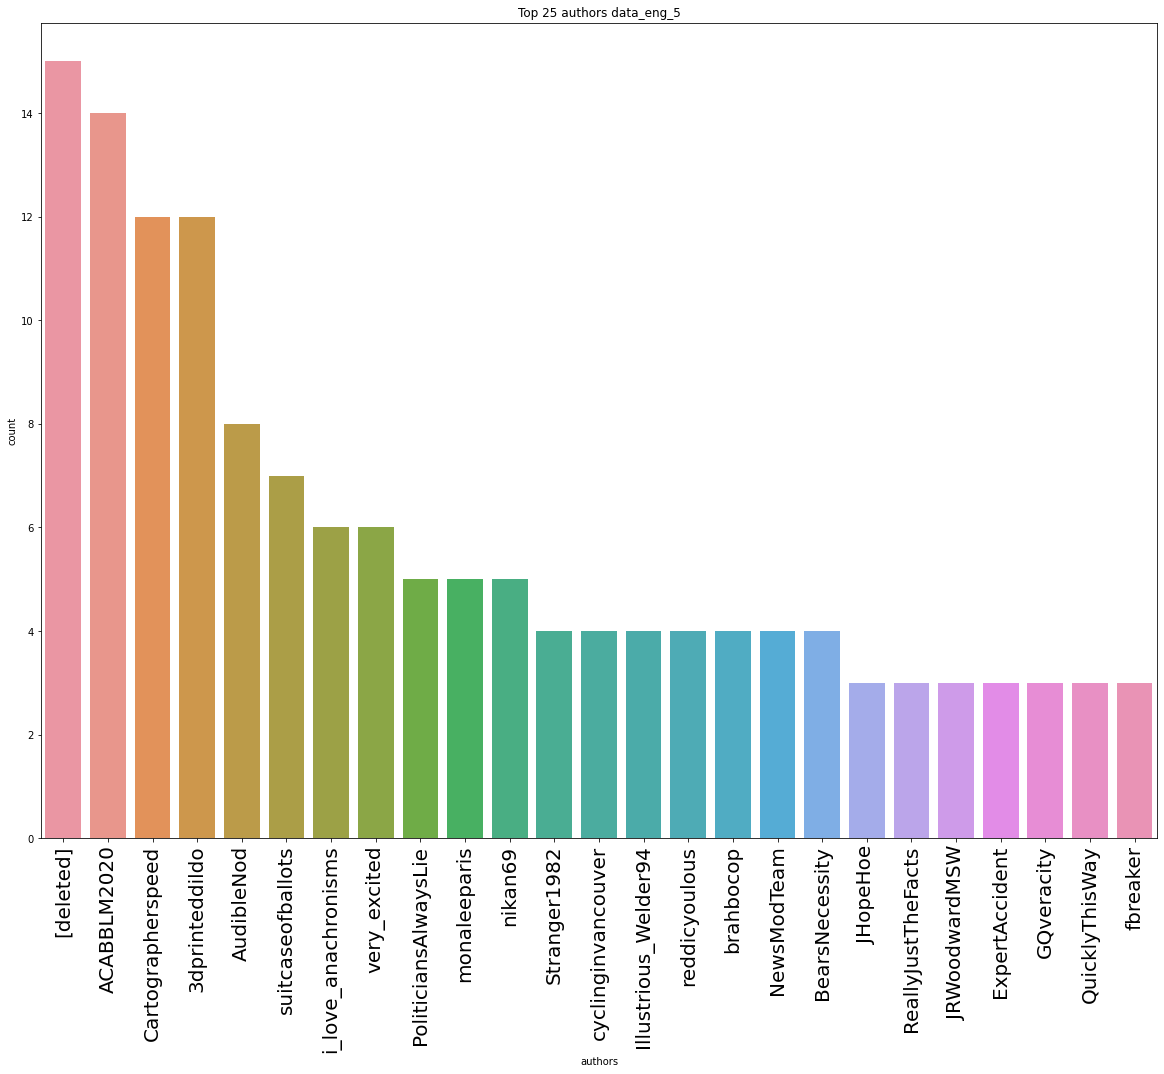

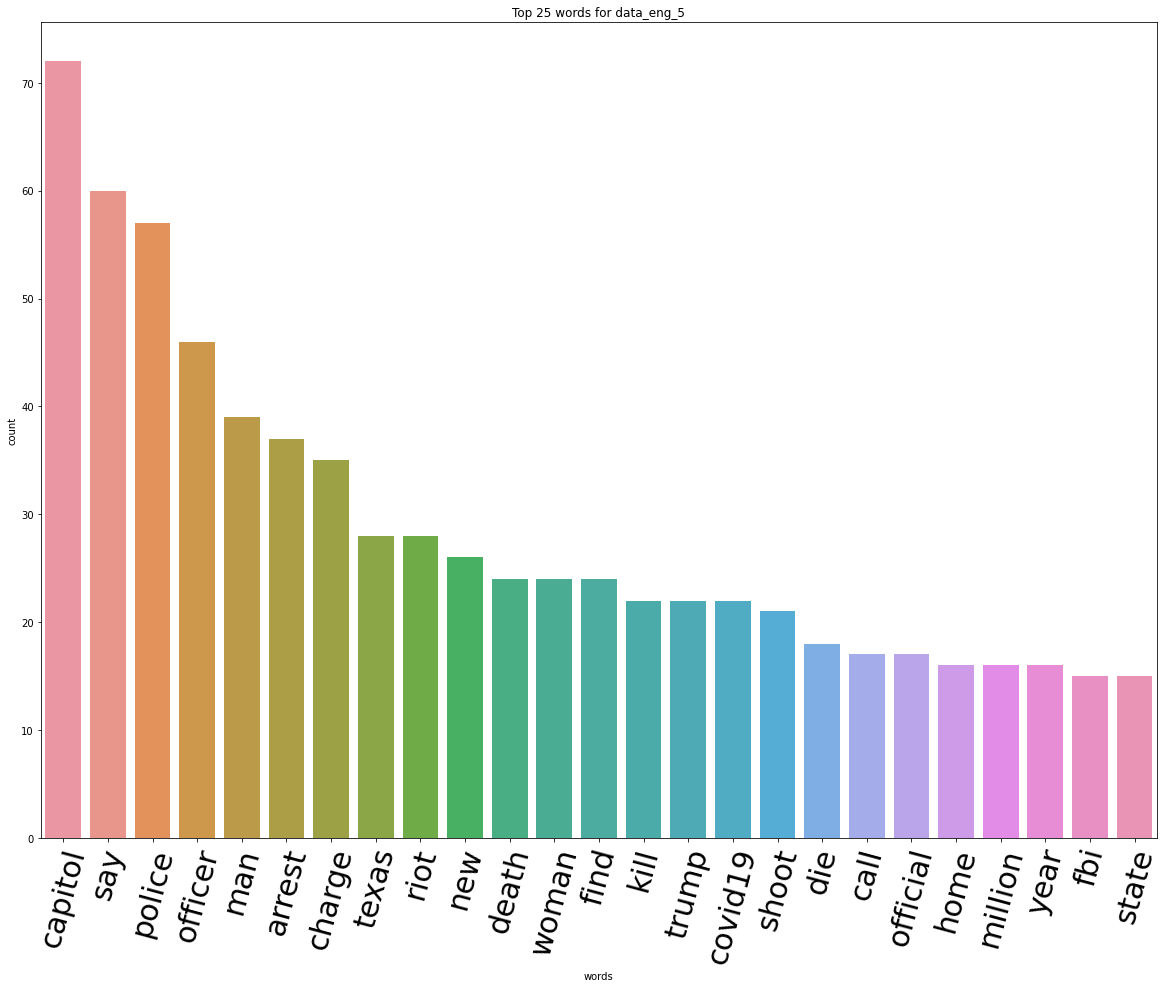

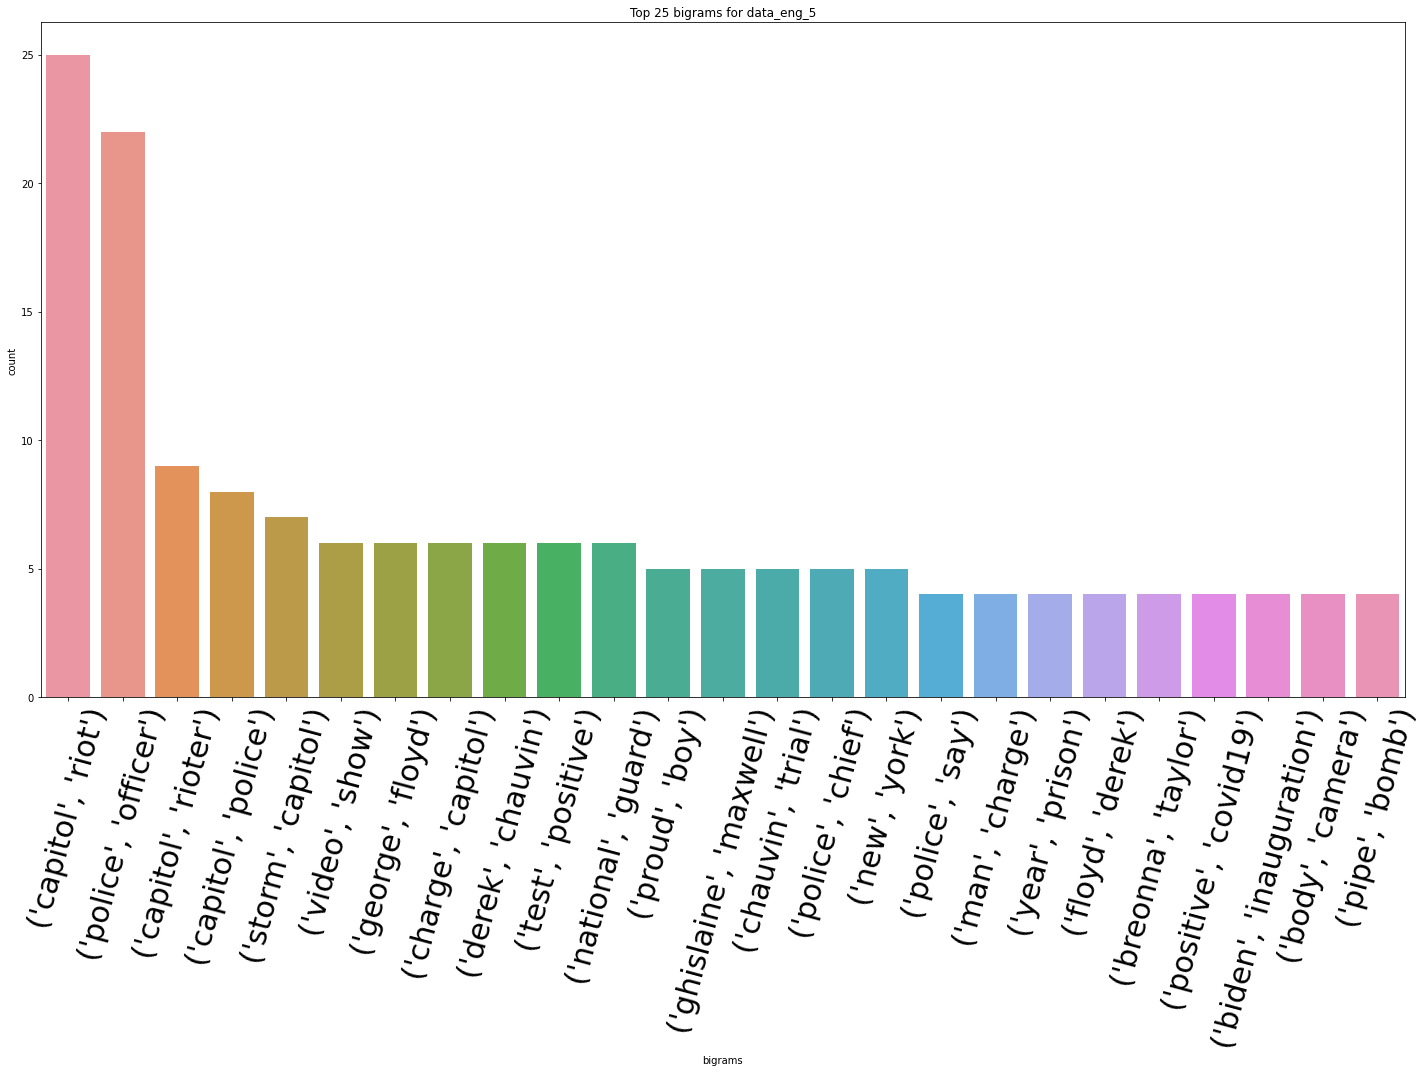

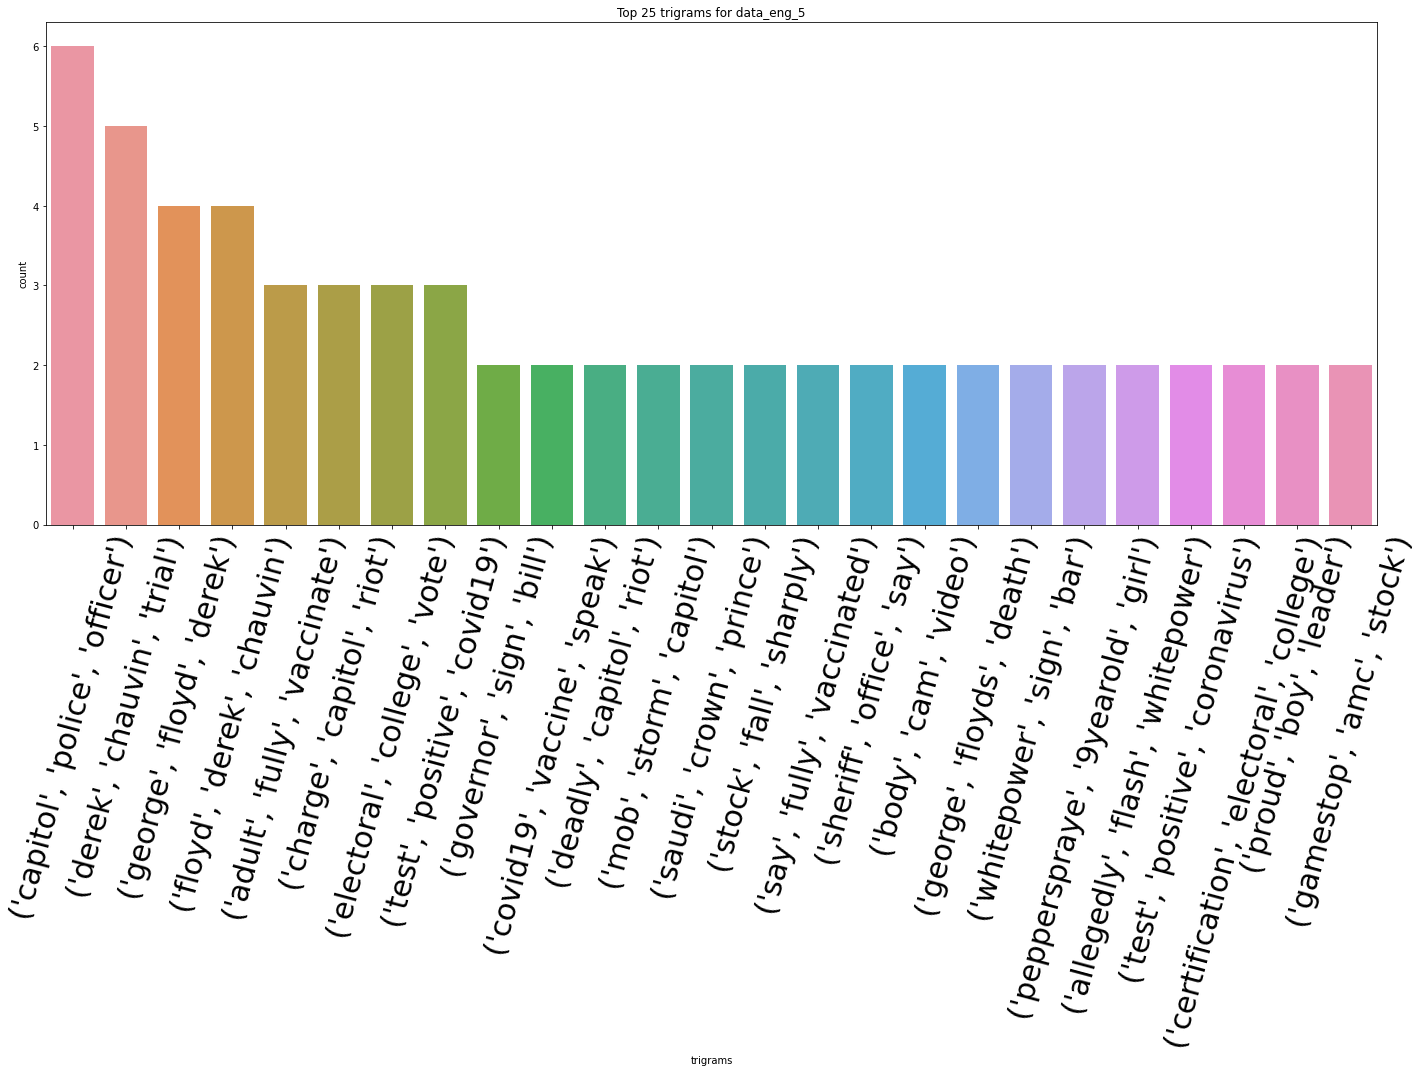

In [33]:
dfs = [data_eng_5]

for df in dfs:
    name = df_name(df)
    


    authors_df = pd.DataFrame(df['Author'].value_counts())
    authors_df = authors_df.reset_index()
    authors_df.columns = ['authors','count']
    top_25_authors = authors_df.head(25)

    plt.figure(figsize=(20,15))
    sns.barplot(x=top_25_authors['authors'], y=top_25_authors['count'])
    plt.title("Top 25 authors " + str(name))
    plt.xticks(rotation=90, size=20)
    
    plt.show() 

    words = df['lemmatized_words'].explode()
    words_df = pd.DataFrame(words.value_counts())
    words_df = words_df.reset_index()
    words_df.columns = ['words','count']
    top_25_words = words_df.head(25)

    plt.figure(figsize=(20,15))
    sns.barplot(x=top_25_words['words'], y=top_25_words['count'])
    plt.title("Top 25 words for " + str(name))
    plt.xticks(rotation=75, size=30)
    plt.savefig('top 25 words.png')
    plt.show()

    bigrams = pd.Series(nltk.ngrams(words,2)).value_counts()
    bigrams_df = pd.DataFrame(bigrams)
    bigrams_df = bigrams_df.reset_index()
    bigrams_df.columns = ['bigrams','count']
    top_25_bigrams = bigrams_df.head(25)

    plt.figure(figsize=(20,15))
    sns.barplot(x=top_25_bigrams['bigrams'], y=top_25_bigrams['count'])
    plt.title("Top 25 bigrams for " + str(name))
    plt.xticks(rotation=75, size=30)
    plt.tight_layout()
    plt.savefig('top 25 bigrams.png')    
    plt.show()

    trigrams = pd.Series(nltk.ngrams(words,3)).value_counts()
    trigrams_df = pd.DataFrame(trigrams)
    trigrams_df = trigrams_df.reset_index()
    trigrams_df.columns = ['trigrams','count']
    top_25_trigrams = trigrams_df.head(25)

    plt.figure(figsize=(20,15))
    sns.barplot(x=top_25_trigrams['trigrams'], y=top_25_trigrams['count'])
    plt.title("Top 25 trigrams for " + str(name))
    plt.xticks(rotation=75, size=30)
    plt.tight_layout()
    plt.savefig('top 25 trigrams.png')  
    plt.show()

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [35]:
tfidf = TfidfVectorizer(ngram_range=(1,3), stop_words='english', min_df=.01)
tfidf_features = tfidf.fit_transform(data_analysis['lemmatized'])

In [36]:
tfidf_vect_df = pd.DataFrame(tfidf_features.todense(), columns = tfidf.get_feature_names())
data_analysis_tfidf = pd.concat([data_analysis, tfidf_vect_df], axis=1)
data_analysis_tfidf = data_analysis_tfidf.drop(['lemmatized'], axis=1)
data_analysis_tfidf = data_analysis_tfidf.drop(['Post ID', 'Title', 'Url', 'Author', 'Score', 'Publish Date',
       'Total No. of Comments', 'Permalink', 'Flair', 'duplicate',
       'Engagement', 'title_case_correct', 'title_words', 'language', 'lemmatized_words', 'score_percentile',
       'comments_percentile', 'engagement_percentile', 'score_band',
       'comm_band'], axis=1)
data_analysis_tfidf

,eng_band,accuse,american,amid,arrest,asian,attack,ban,black,california,...,time,uk,use,vaccine,video,woman,worker,world,year,york
0,1,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5930,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.483638,0.0,...,0.0,0.0,0.471408,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5931,0,0.0,0.0,0.0,0.497455,0.659433,0.563637,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5932,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5933,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
cv = CountVectorizer(ngram_range=(1,3), stop_words='english', min_df=5)
cv_features = cv.fit_transform(data_analysis['lemmatized'])

In [38]:
cv_vect_df = pd.DataFrame(cv_features.todense(), columns = cv.get_feature_names())
data_analysis_cv = pd.concat([data_analysis, cv_vect_df], axis=1)
data_analysis_cv = data_analysis_cv.drop(['lemmatized'], axis=1)
data_analysis_cv = data_analysis_cv.drop(['Post ID', 'Title', 'Url', 'Author', 'Score', 'Publish Date',
       'Total No. of Comments', 'Permalink', 'Flair', 'duplicate',
       'Engagement', 'title_case_correct', 'title_words', 'language', 'lemmatized_words', 'score_percentile',
       'comments_percentile', 'engagement_percentile', 'score_band',
       'comm_band'], axis=1)
data_analysis_cv

,eng_band,10,10 year,100,100 million,1000,10000,11,12,13,...,york city,york time,young,youth,youtube,zealand,zero,zone,zoo,zoom
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5930,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5931,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5932,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5933,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#importing our models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

#Model Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [40]:
#dv = data_analysis_tfidf.eng_band
#ivs = data_analysis_tfidf.drop(['eng_band'], axis=1)

#X_train, X_test, y_train, y_test = train_test_split(ivs, dv, test_size=.2, random_state=8)

In [41]:
#log_reg = LogisticRegression(max_iter=5000)

#C_val = [.0001, .001, .01, .1, 1, 10, 100]
#pen = ['l2']

#param_grid = dict(C = C_val, penalty = pen)

In [42]:
#grid_tfidf = GridSearchCV(log_reg, param_grid= param_grid, cv = 10, scoring = 'roc_auc')

In [43]:
#grid_tfidf.fit(X_train, y_train)

In [44]:
#print(grid_tfidf.best_score_)
#print(grid_tfidf.best_params_)

In [45]:
#log_reg_tfidf_pred = grid_tfidf.predict(X_test)
#print(roc_auc_score(y_test, log_reg_tfidf_pred))
#print(classification_report(y_test, log_reg_tfidf_pred))

In [46]:
dv_2 = data_analysis_cv.eng_band
ivs_2 = data_analysis_cv.drop(['eng_band'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(ivs_2, dv_2, test_size=.2, random_state=8)

In [47]:
log_reg = LogisticRegression(max_iter=5000)

C_val = [.0001, .001, .01, .1, 1, 10, 100]
pen = ['l2']

param_grid = dict(C = C_val, penalty = pen)

In [48]:
grid_tfidf = GridSearchCV(log_reg, param_grid= param_grid, cv = 10, scoring = 'roc_auc')

In [49]:
grid_tfidf.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=5000),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l2']},
             scoring='roc_auc')

In [50]:
grid_tfidf.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [51]:
log_reg = LogisticRegression(C=grid_tfidf.best_params_['C'], penalty=grid_tfidf.best_params_['penalty'], max_iter=5000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict_proba(X_test)[:,1]

In [52]:
from sklearn.metrics import roc_curve, auc

log_fpr, log_tpr, threshold = roc_curve(y_test, y_pred)
log_auc_score = auc(log_fpr, log_tpr)
print(log_auc_score)

0.6925226652583399


In [53]:
# knn

knn = KNeighborsClassifier()

k_range = list(np.arange(2,23,2))
knn_params = dict(n_neighbors=k_range)

In [54]:
#grid = GridSearchCV(knn, param_grid=knn_params, cv = 10, scoring = 'roc_auc')
#grid.fit(X_train, y_train)
#grid.best_params_

In [55]:
knn = KNeighborsClassifier(n_neighbors = 22)
knn.fit(X_train, y_train)
y_pred = knn.predict_proba(X_test)[:,1]

In [56]:
knn_fpr, knn_tpr, threshold = roc_curve(y_test, y_pred)
knn_auc_score = auc(knn_fpr, knn_tpr)
print(knn_auc_score)

0.555118387465892


In [57]:
# svc

svc = SVC()

svc_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  }

In [58]:
#grid = GridSearchCV(svc, svc_params, cv = 10, scoring = 'roc_auc')
#grid.fit(X_train, y_train)
#grid.best_params_

In [59]:
svc = SVC(C=1, probability=True)
svc.fit(X_train, y_train)
y_pred = svc.predict_proba(X_test)[:,1]

In [60]:
svc_fpr, svc_tpr, threshold = roc_curve(y_test, y_pred)
svc_auc_score = auc(svc_fpr, svc_tpr)
print(svc_auc_score)

0.6693997007305695


In [61]:
# rf

rf = RandomForestClassifier()

rf_params = {
    'n_estimators': [10, 25, 50, 75, 100],
    'max_features': [None, 'auto', 'log2'],
    'max_depth' : [2,3,4,5,6],
}

In [62]:
#grid = GridSearchCV(rf, rf_params, cv = 10, scoring = 'roc_auc')
#grid.fit(X_train, y_train)
#grid.best_params_

In [63]:
rf = RandomForestClassifier(max_depth= 6, max_features= 'auto',n_estimators= 100)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_test)[:,1]

In [64]:
rf_fpr, rf_tpr, threshold = roc_curve(y_test, y_pred)
rf_auc_score = auc(rf_fpr, rf_tpr)
print(rf_auc_score)

0.6335137751958454


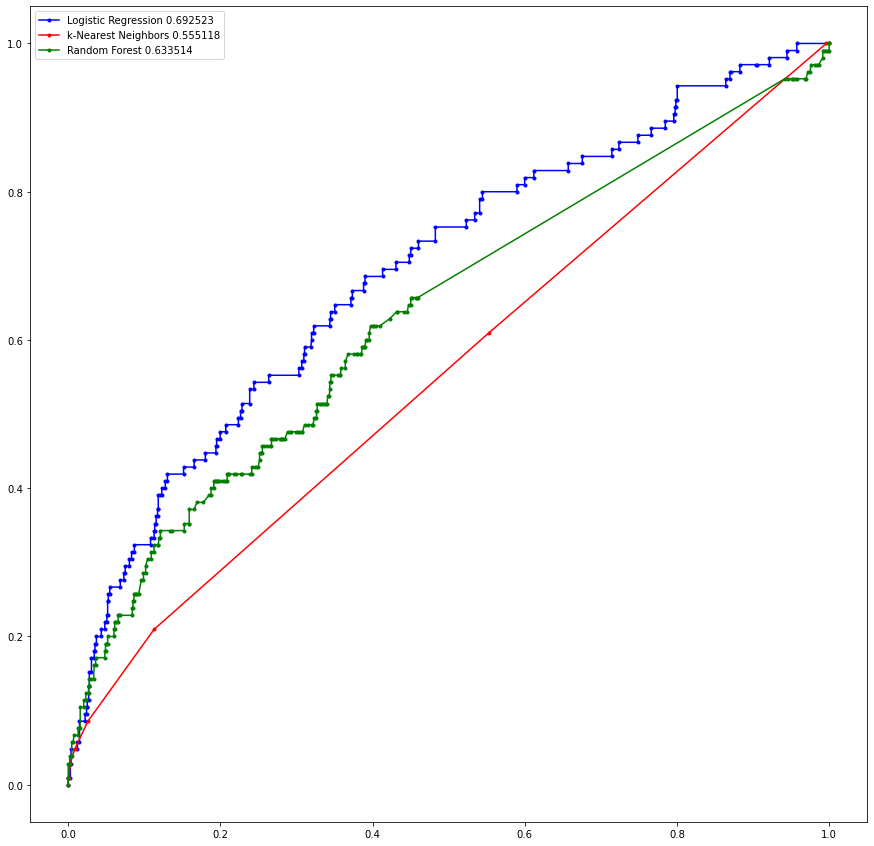

In [65]:
fig, heat = plt.subplots(figsize = (15,15))
plt.plot(log_fpr, log_tpr, marker='.', color='blue', label='Logistic Regression %f' % log_auc_score)
plt.plot(knn_fpr, knn_tpr, marker='.', color='red', label='k-Nearest Neighbors %f' % knn_auc_score)
plt.plot(rf_fpr, rf_tpr, marker='.', color='green', label='Random Forest %f' % rf_auc_score)

plt.legend()
plt.savefig('r_news_aucs.png')
plt.show()

In [66]:
feature_names = data_analysis_cv.drop(['eng_band'], axis=1).columns
feature_names = list(feature_names)
feature_names

['10',
 '10 year',
 '100',
 '100 million',
 '1000',
 '10000',
 '11',
 '12',
 '13',
 '13yearold',
 '14',
 '14yearold',
 '15',
 '15 year',
 '150',
 '15000',
 '16',
 '16yearold',
 '18',
 '19',
 '1st',
 '20',
 '20 year',
 '200',
 '2019',
 '2020',
 '2021',
 '2022',
 '22',
 '23',
 '24',
 '25',
 '2570',
 '2570 drop',
 '2570 drop email',
 '26',
 '27',
 '27 billion',
 '27 year',
 '29',
 '2nd',
 '30',
 '30 year',
 '3000',
 '32',
 '336',
 '336 496',
 '336 496 2570',
 '3yearold',
 '40',
 '400',
 '4000',
 '400000',
 '41',
 '44',
 '45',
 '48',
 '496',
 '496 2570',
 '496 2570 drop',
 '4yearold',
 '50',
 '50 state',
 '500',
 '500000',
 '5yearold',
 '60',
 '600',
 '65',
 '70',
 '700',
 '737',
 '777',
 '78',
 '80',
 '81',
 '90',
 '91',
 '911',
 '92',
 '99',
 '9yearold',
 'abandon',
 'able',
 'abortion',
 'abram',
 'abuse',
 'accept',
 'access',
 'accidentally',
 'accord',
 'account',
 'accuse',
 'accuse kill',
 'act',
 'action',
 'active',
 'activist',
 'actor',
 'actress',
 'actually',
 'ad',
 'add',
 

In [67]:
importance = log_reg.coef_[0]

In [68]:
importance = list(np.round(importance, decimals=5))

In [69]:
features_dict = {'feature':feature_names, 'importance': importance}

Feature: 0, Score: -0.12088
Feature: 1, Score: 0.06272
Feature: 2, Score: 0.33526
Feature: 3, Score: 0.17829
Feature: 4, Score: -0.03507
Feature: 5, Score: 0.21011
Feature: 6, Score: 0.05966
Feature: 7, Score: 0.03431
Feature: 8, Score: 0.03939
Feature: 9, Score: 0.01727
Feature: 10, Score: 0.02753
Feature: 11, Score: 0.02892
Feature: 12, Score: -0.03851
Feature: 13, Score: 0.05401
Feature: 14, Score: 0.15005
Feature: 15, Score: 0.12525
Feature: 16, Score: 0.04192
Feature: 17, Score: 0.06459
Feature: 18, Score: -0.10435
Feature: 19, Score: 0.02147
Feature: 20, Score: 0.05156
Feature: 21, Score: 0.02710
Feature: 22, Score: 0.03319
Feature: 23, Score: 0.01061
Feature: 24, Score: -0.03279
Feature: 25, Score: -0.10030
Feature: 26, Score: -0.12556
Feature: 27, Score: -0.02653
Feature: 28, Score: 0.05216
Feature: 29, Score: 0.06085
Feature: 30, Score: -0.06722
Feature: 31, Score: 0.02909
Feature: 32, Score: -0.03510
Feature: 33, Score: -0.03067
Feature: 34, Score: -0.03067
Feature: 35, Score

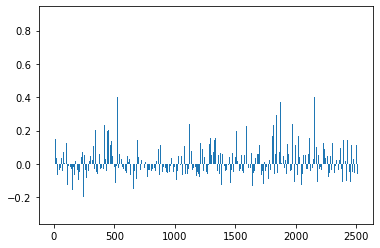

In [70]:
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [71]:
feature_importances = pd.DataFrame(features_dict)
feature_importances.sort_values(by='importance', ascending=False).head(10)

,feature,importance
2325,trump,0.88635
397,capitol,0.84362
2260,texas,0.60175
1582,officer,0.47972
2155,stop,0.46281
299,biden,0.44601
1094,home,0.40991
2156,store,0.40332
527,colorado,0.40111
884,fbi,0.39487


In [72]:
feature_importances_ngram = pd.DataFrame(features_dict)
feature_importances_ngram['ngram'] = feature_importances_ngram['feature'].str.contains(' ')
feature_importances_ngram = feature_importances_ngram[feature_importances_ngram.ngram]
feature_importances_ngram.sort_values(by='importance', ascending=False).head(10)

,feature,importance,ngram
406,capitol rioter,0.32108,True
453,charge capitol,0.25032,True
1725,police officer,0.24491,True
528,colorado spring,0.20337,True
1697,pipe bomb,0.20276,True
977,gamestop share,0.20146,True
403,capitol riot,0.19681,True
327,body camera,0.19666,True
1511,national guard,0.19599,True
2506,year prison,0.19464,True


In [73]:
# label and try to remove specific high-engagement stories X
# downsample labeled stories
# Named entity recognition in spacy
# Percentage of top stories are "major" stories
# proof of concept, limited by IVs
# next steps: story/body text, more data (decades)
# present call, pause, final call, done
# word embedding/raw words labelling for general labels


In [74]:
data_labelled = pd.DataFrame(data)
data_labelled['labels'] = 0
data_labelled = data_labelled.reset_index()
data_labelled = data_labelled.drop('index',axis=1)

In [75]:
dl_range = range(0,data_labelled.shape[0]-1)
story_labels = ['capitol','chauvin','floyd','breonna','ghislaine','rittenhouse','inauguration']

for i in dl_range:
    if any(item in data_labelled['title_words'][i] for item in story_labels) == True:
        data_labelled['labels'].iloc[i] = 1
    else:
        data_labelled['labels'].iloc[i] = 0

C:\Users\webge\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [76]:
data_labelled['labels'][data_labelled['eng_band']=='Top 5'].value_counts()

0    448
1     95
Name: labels, dtype: int64

In [77]:
data_non_major = pd.DataFrame(data_labelled[data_labelled['labels'] == 0])
data_non_major.reset_index()

,index,Post ID,Title,Url,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair,...,language,lemmatized,lemmatized_words,score_percentile,comments_percentile,engagement_percentile,score_band,comm_band,eng_band,labels
0,0,lr3xap,Man dies after police kneel on his neck for ne...,https://amp.cnn.com/cnn/2021/02/23/us/angelo-q...,monaleeparis,100226,2021-02-23 20:43:30,17754,/r/news/comments/lr3xap/man_dies_after_police_...,NaN,...,en,man die after police kneel on his neck for nea...,"[man, die, police, kneel, neck, nearly, 5, min...",0.999908,0.999631,1.000000,Top 5,Top 5,Top 5,0
1,1,lsmh36,Texan files $1 billion class-action lawsuit af...,https://abcnews.go.com/US/texan-files-billion-...,ACABBLM2020,97551,2021-02-25 17:30:11,14574,/r/news/comments/lsmh36/texan_files_1_billion_...,NaN,...,en,texan file 1 billion classaction lawsuit after...,"[texan, file, 1, billion, classaction, lawsuit...",0.999631,0.999170,0.999908,Top 5,Top 5,Top 5,0
2,2,ls7xmj,Trump tax returns are now in the hands of the ...,https://www.cnbc.com/2021/02/25/trump-tax-retu...,[deleted],98318,2021-02-25 06:38:18,12719,/r/news/comments/ls7xmj/trump_tax_returns_are_...,NaN,...,en,trump tax return be now in the hand of the man...,"[trump, tax, return, hand, manhattan, district...",0.999723,0.998709,0.999816,Top 5,Top 5,Top 5,0
3,3,laun1r,Minneapolis police officers must keep body cam...,https://www.cnn.com/2021/02/02/us/minneapolis-...,dlkapt3,103302,2021-02-02 04:42:35,7312,/r/news/comments/laun1r/minneapolis_police_off...,NaN,...,en,minneapolis police officer must keep body came...,"[minneapolis, police, officer, must, keep, bod...",1.000000,0.995020,0.999723,Top 5,Top 5,Top 5,0
4,4,lsbgop,Costco lifts minimum wage above Amazon or Targ...,https://www.reuters.com/article/us-costco-whol...,candordirect,99299,2021-02-25 09:11:08,8124,/r/news/comments/lsbgop/costco_lifts_minimum_w...,NaN,...,en,costco lift minimum wage above amazon or targe...,"[costco, lift, minimum, wage, amazon, target, ...",0.999816,0.996127,0.999631,Top 5,Top 5,Top 5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10076,10838,mxf36e,Bones of Black children killed in police bombi...,https://www.theguardian.com/us-news/2021/apr/2...,mod_89,1,2021-04-24 00:35:28,9,/r/news/comments/mxf36e/bones_of_black_childre...,NaN,...,en,bone of black child kill in police bombing use...,"[bone, black, child, kill, police, bombing, us...",0.332196,0.091534,0.017661,Bottom 50,Bottom 50,Bottom 50,0
10077,10839,mjb8qw,A juvenile has been arrested following a video...,https://www.cnn.com/2021/04/03/us/asian-couple...,Piranha_ChuckNorris,5,2021-04-03 08:57:30,5,/r/news/comments/mjb8qw/a_juvenile_has_been_ar...,NaN,...,en,a juvenile have be arrest follow a videotape a...,"[juvenile, arrest, follow, videotape, attack, ...",0.731901,0.045513,0.017661,Middle 45,Bottom 50,Bottom 50,0
10078,10840,n3oquf,(Australia) 80yo fisher finds himself trapped ...,https://www.abc.net.au/news/2021-05-03/fisherm...,LuckyBdx4,1,2021-05-02 22:29:06,9,/r/news/comments/n3oquf/australia_80yo_fisher_...,NaN,...,en,australia 80yo fisher find himself trap in a t...,"[australia, 80yo, fisher, find, trap, tinny, t...",0.332196,0.091534,0.017661,Bottom 50,Bottom 50,Bottom 50,0
10079,10841,n545c8,Minorities underrepresented in vaccinated popu...,https://www.kxly.com/minorities-underrepresent...,MasterRazz,1,2021-05-04 18:40:19,9,/r/news/comments/n545c8/minorities_underrepres...,NaN,...,en,minority underrepresented in vaccinated popula...,"[minority, underrepresented, vaccinated, popul...",0.332196,0.091534,0.017661,Bottom 50,Bottom 50,Bottom 50,0


In [78]:
data_eng_5 = data_non_major[data_non_major['eng_band'] == 'Top 5']
data_eng_50 = data_non_major[data_non_major['eng_band'] == 'Bottom 50']

In [79]:
data_analysis = data_eng_5.append(data_eng_50, ignore_index=True)
data_analysis['eng_band'] = data_analysis['eng_band'].replace({'Top 5':1, 'Bottom 50':0})

In [80]:
cv = CountVectorizer(ngram_range=(1,3), stop_words='english', min_df=5)
cv_features = cv.fit_transform(data_analysis['lemmatized'])

In [81]:
cv_vect_df = pd.DataFrame(cv_features.todense(), columns = cv.get_feature_names())
data_analysis_cv = pd.concat([data_analysis, cv_vect_df], axis=1)
data_analysis_cv = data_analysis_cv.drop(['lemmatized'], axis=1)
data_analysis_cv = data_analysis_cv.drop(['Post ID', 'Title', 'Url', 'Author', 'Score', 'Publish Date',
       'Total No. of Comments', 'Permalink', 'Flair', 'duplicate',
       'Engagement', 'title_case_correct', 'title_words', 'language', 'lemmatized_words', 'score_percentile',
       'comments_percentile', 'engagement_percentile', 'score_band',
       'comm_band'], axis=1)
data_analysis_cv

,eng_band,labels,10,10 year,100,100 million,1000,10000,11,12,...,york city,york time,young,youth,youtube,zealand,zero,zone,zoo,zoom
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5566,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5567,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
dv_2 = data_analysis_cv.eng_band
ivs_2 = data_analysis_cv.drop(['eng_band'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(ivs_2, dv_2, test_size=.2, random_state=8)

In [83]:
log_reg = LogisticRegression(max_iter=5000)

C_val = [.0001, .001, .01, .1, 1, 10, 100]
pen = ['l2']

param_grid = dict(C = C_val, penalty = pen)

In [84]:
grid_tfidf = GridSearchCV(log_reg, param_grid= param_grid, cv = 10, scoring = 'roc_auc')

In [85]:
grid_tfidf.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=5000),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l2']},
             scoring='roc_auc')

In [86]:
grid_tfidf.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [87]:
log_reg = LogisticRegression(C=grid_tfidf.best_params_['C'], penalty=grid_tfidf.best_params_['penalty'], max_iter=5000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict_proba(X_test)[:,1]

In [88]:
from sklearn.metrics import roc_curve, auc

log_fpr, log_tpr, threshold = roc_curve(y_test, y_pred)
log_auc_score = auc(log_fpr, log_tpr)
print(log_auc_score)

0.6563554700032082


In [89]:
# knn

knn = KNeighborsClassifier()

k_range = list(np.arange(2,23,2))
knn_params = dict(n_neighbors=k_range)

In [90]:
#grid = GridSearchCV(knn, param_grid=knn_params, cv = 10, scoring = 'roc_auc')
#grid.fit(X_train, y_train)
#grid.best_params_

In [91]:
knn = KNeighborsClassifier(n_neighbors = 22)
knn.fit(X_train, y_train)
y_pred = knn.predict_proba(X_test)[:,1]

In [92]:
knn_fpr, knn_tpr, threshold = roc_curve(y_test, y_pred)
knn_auc_score = auc(knn_fpr, knn_tpr)
print(knn_auc_score)

0.5417131857555342


In [93]:
# svc

svc = SVC()

svc_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  }

In [94]:
#grid = GridSearchCV(svc, svc_params, cv = 10, scoring = 'roc_auc')
#grid.fit(X_train, y_train)
#grid.best_params_

In [95]:
svc = SVC(C=1, probability=True)
svc.fit(X_train, y_train)
y_pred = svc.predict_proba(X_test)[:,1]

In [96]:
svc_fpr, svc_tpr, threshold = roc_curve(y_test, y_pred)
svc_auc_score = auc(svc_fpr, svc_tpr)
print(svc_auc_score)

0.6586268848251524


In [97]:
# rf

rf = RandomForestClassifier()

rf_params = {
    'n_estimators': [10, 25, 50, 75, 100],
    'max_features': [None, 'auto', 'log2'],
    'max_depth' : [2,3,4,5,6],
}

In [98]:
#grid = GridSearchCV(rf, rf_params, cv = 10, scoring = 'roc_auc')
#grid.fit(X_train, y_train)
#grid.best_params_

In [99]:
rf = RandomForestClassifier(max_depth= 6, max_features= 'auto',n_estimators= 100)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_test)[:,1]

In [100]:
rf_fpr, rf_tpr, threshold = roc_curve(y_test, y_pred)
rf_auc_score = auc(rf_fpr, rf_tpr)
print(rf_auc_score)

0.6687776708373436


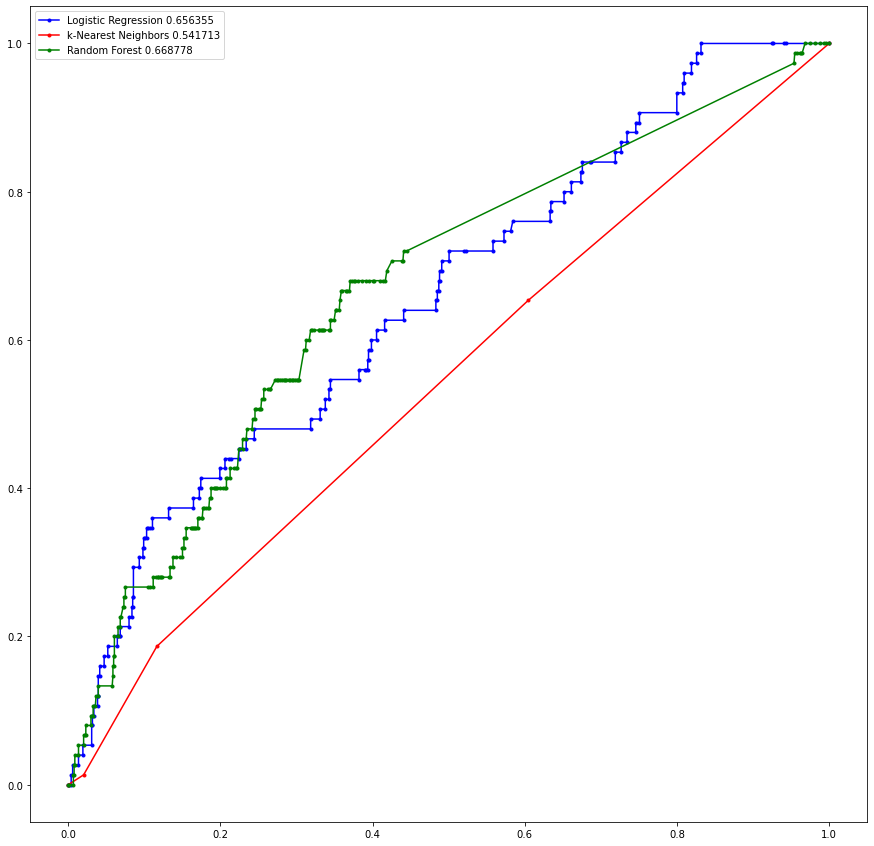

In [101]:
fig, heat = plt.subplots(figsize = (15,15))
plt.plot(log_fpr, log_tpr, marker='.', color='blue', label='Logistic Regression %f' % log_auc_score)
plt.plot(knn_fpr, knn_tpr, marker='.', color='red', label='k-Nearest Neighbors %f' % knn_auc_score)
plt.plot(rf_fpr, rf_tpr, marker='.', color='green', label='Random Forest %f' % rf_auc_score)

plt.legend()
plt.savefig('r_news_aucs_nonmaj.png')
plt.show()

In [102]:
feature_names = data_analysis_cv.drop(['eng_band'], axis=1).columns
feature_names = list(feature_names)
feature_names

['labels',
 '10',
 '10 year',
 '100',
 '100 million',
 '1000',
 '10000',
 '11',
 '12',
 '13',
 '13yearold',
 '14',
 '15',
 '15 year',
 '150',
 '15000',
 '16',
 '16yearold',
 '18',
 '19',
 '1st',
 '20',
 '20 year',
 '200',
 '2019',
 '2020',
 '2021',
 '2022',
 '22',
 '24',
 '25',
 '2570',
 '2570 drop',
 '2570 drop email',
 '26',
 '27',
 '27 billion',
 '27 year',
 '29',
 '2nd',
 '30',
 '30 year',
 '3000',
 '32',
 '336',
 '336 496',
 '336 496 2570',
 '3yearold',
 '40',
 '400',
 '4000',
 '400000',
 '41',
 '44',
 '45',
 '48',
 '496',
 '496 2570',
 '496 2570 drop',
 '4yearold',
 '50',
 '50 state',
 '500',
 '500000',
 '5yearold',
 '60',
 '600',
 '65',
 '70',
 '700',
 '737',
 '777',
 '78',
 '80',
 '81',
 '90',
 '91',
 '911',
 '92',
 '99',
 '9yearold',
 'abandon',
 'able',
 'abortion',
 'abram',
 'abuse',
 'accept',
 'access',
 'accidentally',
 'accord',
 'account',
 'accuse',
 'accuse kill',
 'act',
 'action',
 'active',
 'activist',
 'actor',
 'actress',
 'actually',
 'ad',
 'add',
 'address',

In [103]:
importance = log_reg.coef_[0]

In [104]:
importance = list(np.round(importance, decimals=5))

In [105]:
features_dict = {'feature':feature_names, 'importance': importance}

Feature: 0, Score: 0.00000
Feature: 1, Score: -0.11752
Feature: 2, Score: 0.04963
Feature: 3, Score: 0.33008
Feature: 4, Score: 0.14594
Feature: 5, Score: -0.04232
Feature: 6, Score: 0.09149
Feature: 7, Score: 0.11422
Feature: 8, Score: 0.11763
Feature: 9, Score: 0.02545
Feature: 10, Score: 0.00234
Feature: 11, Score: -0.03900
Feature: 12, Score: 0.02948
Feature: 13, Score: 0.04098
Feature: 14, Score: 0.06734
Feature: 15, Score: 0.05672
Feature: 16, Score: 0.10044
Feature: 17, Score: 0.04987
Feature: 18, Score: -0.09809
Feature: 19, Score: 0.02066
Feature: 20, Score: 0.04345
Feature: 21, Score: 0.02820
Feature: 22, Score: 0.04659
Feature: 23, Score: 0.01716
Feature: 24, Score: -0.03834
Feature: 25, Score: -0.11712
Feature: 26, Score: -0.11554
Feature: 27, Score: 0.06409
Feature: 28, Score: 0.05155
Feature: 29, Score: -0.05371
Feature: 30, Score: 0.01126
Feature: 31, Score: -0.04052
Feature: 32, Score: -0.03708
Feature: 33, Score: -0.03708
Feature: 34, Score: -0.04595
Feature: 35, Score

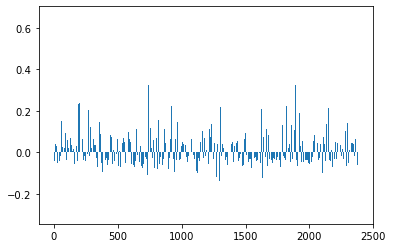

In [106]:
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [107]:
feature_importances = pd.DataFrame(features_dict)
feature_importances.sort_values(by='importance', ascending=False).head(10)

,feature,importance
2199,trump,0.65720
1497,officer,0.58418
2135,texas,0.46690
912,fully,0.43385
616,dc,0.41339
1376,minute,0.40788
1314,mask,0.38285
1174,judge,0.38151
1504,official,0.37290
1237,lawsuit,0.37229


In [108]:
feature_importances_ngram = pd.DataFrame(features_dict)
feature_importances_ngram['ngram'] = feature_importances_ngram['feature'].str.contains(' ')
feature_importances_ngram = feature_importances_ngram[feature_importances_ngram.ngram]
feature_importances_ngram.sort_values(by='importance', ascending=False).head(10)

,feature,importance,ngram
1599,pipe bomb,0.21394,True
1626,police officer,0.21321,True
923,gamestop share,0.20933,True
1625,police chief,0.20921,True
959,governor sign,0.19810,True
1647,positive covid19,0.19419,True
1632,police shooting,0.19403,True
1342,mental health,0.19316,True
1022,high school,0.18852,True
2130,test positive,0.18795,True
